

## **Analysis of CROCO controls for the Humboldt current system**. 
### Improvements of NCCHILE/Orlando control - Experiment (2): Sensitivity to daily variations on the atmospheric forcing.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmaps
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import geopandas as gpd
import xesmf as xe
import glob
import regionmask
import xgcm
import dask
import os
from dask.diagnostics import ProgressBar

plt.rc('font', size=16)
plt.rc('font', size=16)

The simulation forced by ERA5 and GLORYS12V1, has the posibility to improve (in terms of SST) due to the forcing files diurnal variability (ERA5). To include that data in the model, it was needed to turn off the ANA_DIURNAL_SW cppdefs key, because the diurnal cycle of radiation will be contained in the bulk forcing files. Given that configuration, in this notebook i will process the simulations forced by 6H ERA5 and 3H ERA5 fields and check for differences against the control simulation (Daily averages of ERA5). 

That said, i will now load the data ...

In [25]:
#Load grid data
coastmask   = gpd.read_file('~/storage/VECTORIAL/limites/ChileCOASTMASK.shp')
coastline   = gpd.read_file('~/storage/VECTORIAL/limites/lnealitoral/lineadecosta.shp')

#My model
grid = xr.open_dataset('data/CROCO/OUTPUT/TESTSIM/24HERA5_GLORYS12V1/testsim_grd.nc').squeeze().load()
grid = grid[['h','xi_rho','eta_rho','lon_rho','lat_rho','x_rho','y_rho','mask_rho']]
grid['lon_rho'] = (grid.lon_rho+180)%360-180
grid

<xarray.Dataset>
Dimensions:   (eta_rho: 294, xi_rho: 325)
Coordinates:
  * xi_rho    (xi_rho) int64 0 1 2 3 4 5 6 7 ... 317 318 319 320 321 322 323 324
  * eta_rho   (eta_rho) int64 0 1 2 3 4 5 6 7 ... 287 288 289 290 291 292 293
Data variables:
    h         (eta_rho, xi_rho) float32 433.6 433.6 450.8 ... 10.0 10.0 10.0
    lon_rho   (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.03 -70.0
    lat_rho   (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.0 -27.0 -27.0
    x_rho     (eta_rho, xi_rho) float32 -0.03125 2.557e+03 ... 8.912e+05
    y_rho     (eta_rho, xi_rho) float32 -0.03125 -0.03125 ... 7.784e+05
    mask_rho  (eta_rho, xi_rho) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                     North-Central Chile
    date:                      05-Dec-2022
    type:                      CROCO grid file
    history:                   Fri Jan 27 13:40:48 2023: ncpdq -L 5 -7 backup...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [14]:
#Load OSTIA reference dataset:
if os.path.exists('data/ZARR/ostia'):
    ostia = xr.open_zarr('data/ZARR/ostia').chunk({'time':1})
    ostia = ostia.chunk({'lat':len(ostia.lat),'lon':len(ostia.lon)})
else:
    raise FileNotFoundError('zarr store doesnt exists!')

ostia_clim = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').rename({'analysed_sst':'sst'})

In [3]:
#Load testsim control dataset: 
if os.path.exists('data/ZARR/testsim_control'):
    testsim_control = xr.open_zarr('data/ZARR/testsim_control').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

testsim_control['lon_rho'] = testsim_control.lon_rho.load()
testsim_control['lat_rho'] = testsim_control.lat_rho.load()

In [4]:
#Load testsim 6HERA5 dataset: 
if os.path.exists('data/ZARR/testsim_6HERA5'):
    testsim_6H = xr.open_zarr('data/ZARR/testsim_6HERA5').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

testsim_6H['lon_rho'] = testsim_6H.lon_rho.load()
testsim_6H['lat_rho'] = testsim_6H.lat_rho.load()

In [5]:
#Load testsim 6HERA5 dataset: 
if os.path.exists('data/ZARR/testsim_3HERA5'):
    testsim_3H = xr.open_zarr('data/ZARR/testsim_3HERA5').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

testsim_3H['lon_rho'] = testsim_3H.lon_rho.load()
testsim_3H['lat_rho'] = testsim_3H.lat_rho.load()


Data loaded. Now i will compute the bias, rmse, correlation and anomaly correlation of each simulation against OSTIA. 

In [6]:
#Target dates for the analysis !
ttime = pd.date_range('2006-04','2008', freq='d')[:-1]

In [22]:
#Interpolate horizontal grids
with ProgressBar():
    reference       = ostia.reindex({'time':ttime},method='nearest')
    clim            = ostia_clim.reindex({'lat':reference.lat.values,'lon':reference.lon.values})
    husk            = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                        'lon':(['lon'], reference.lon.values, reference.lon.attrs)})


    regridder       = xe.Regridder(testsim_control.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
    testsim_control_bias    = regridder(testsim_control['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(testsim_control.eta_rho),'xi_rho':len(testsim_control.xi_rho)}))
    testsim_control_bias    = testsim_control_bias.where(testsim_control_bias>0).reindex({'time':ttime},method='nearest')
    testsim_control_corr    = xr.corr(testsim_control_bias, reference.sst, dim='time').load()
    testsim_control_acorr   = xr.corr(testsim_control_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                                      reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    testsim_control_bias    = (testsim_control_bias-reference.sst).load()


    regridder       = xe.Regridder(testsim_6H.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
    testsim_6H_bias    = regridder(testsim_6H['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(testsim_6H.eta_rho),'xi_rho':len(testsim_6H.xi_rho)}))
    testsim_6H_bias    = testsim_6H_bias.where(testsim_6H_bias>0).reindex({'time':ttime},method='nearest')
    testsim_6H_corr    = xr.corr(testsim_6H_bias, reference.sst, dim='time').load()
    testsim_6H_acorr   = xr.corr(testsim_6H_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                                 reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    testsim_6H_bias    = (testsim_6H_bias-reference.sst).load()


    regridder       = xe.Regridder(testsim_3H.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
    testsim_3H_bias    = regridder(testsim_3H['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(testsim_3H.eta_rho),'xi_rho':len(testsim_3H.xi_rho)}))
    testsim_3H_bias    = testsim_3H_bias.where(testsim_3H_bias>0).reindex({'time':ttime},method='nearest')
    testsim_3H_corr    = xr.corr(testsim_3H_bias, reference.sst, dim='time').load()
    testsim_3H_acorr   = xr.corr(testsim_3H_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                                 reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    testsim_3H_bias    = (testsim_3H_bias-reference.sst).load()


[####################################    ] | 91% Completed | 43.15 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.02 s
[#####################################   ] | 92% Completed | 50.68 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.76 s
[########################################] | 100% Completed | 30.09 s
[####################################    ] | 91% Completed | 43.51 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.33 s
[#####################################   ] | 92% Completed | 50.03 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.00 s
[########################################] | 100% Completed | 30.02 s
[####################################    ] | 91% Completed | 42.74 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 46.49 s
[#####################################   ] | 92% Completed | 50.09 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.07 s
[########################################] | 100% Completed | 30.50 s


Now the bias and correlation are computed and loaded into computer memory so i can plot them...

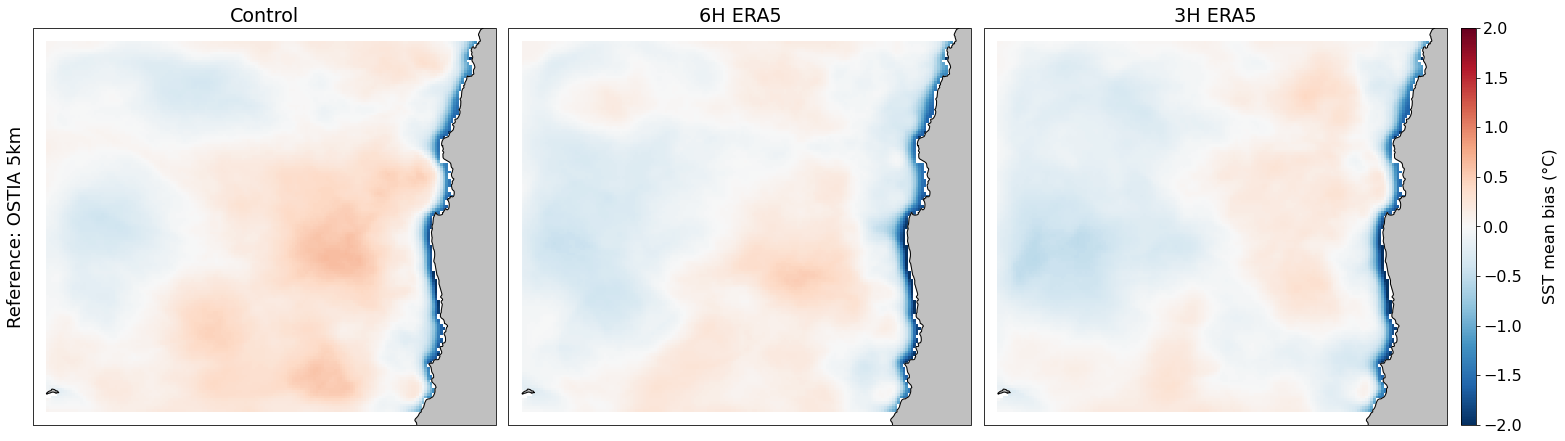

In [29]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Control','6H ERA5','3H ERA5']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='RdBu_r'
norm=mcolors.Normalize(-2,2)
m=ax[0].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_6H_bias.lon,testsim_6H_bias.lat, testsim_6H_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_3H_bias.lon,testsim_3H_bias.lat, testsim_3H_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST mean bias (°C)')

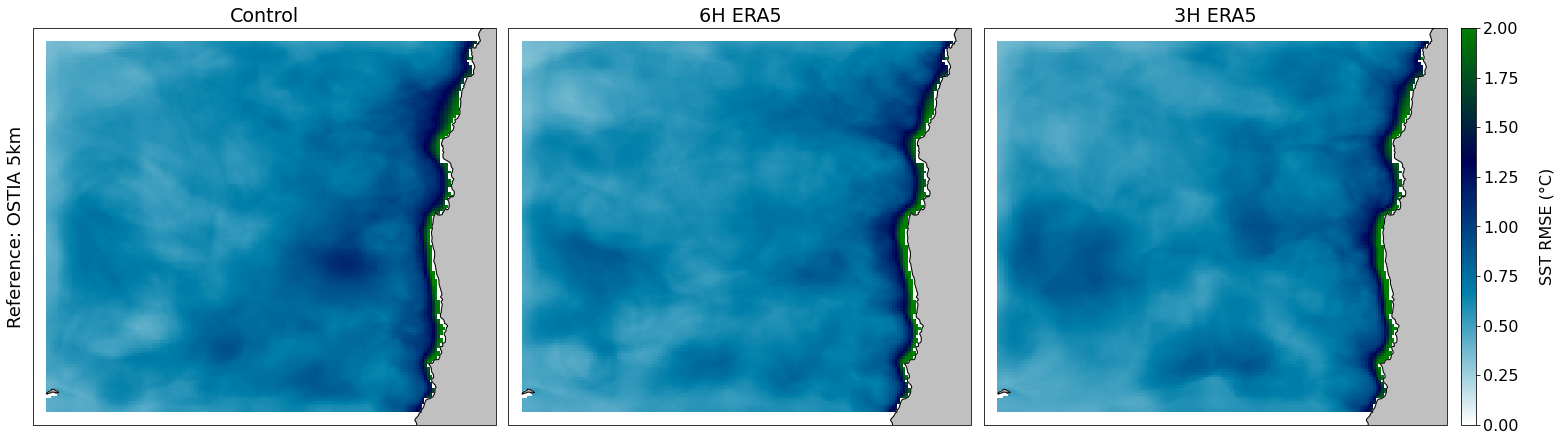

In [36]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Control','6H ERA5','3H ERA5']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='ocean_r'
norm=mcolors.Normalize(0,2)
m=ax[0].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, (testsim_control_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_6H_bias.lon,testsim_6H_bias.lat, (testsim_6H_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_3H_bias.lon,testsim_3H_bias.lat, (testsim_3H_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST RMSE (°C)')

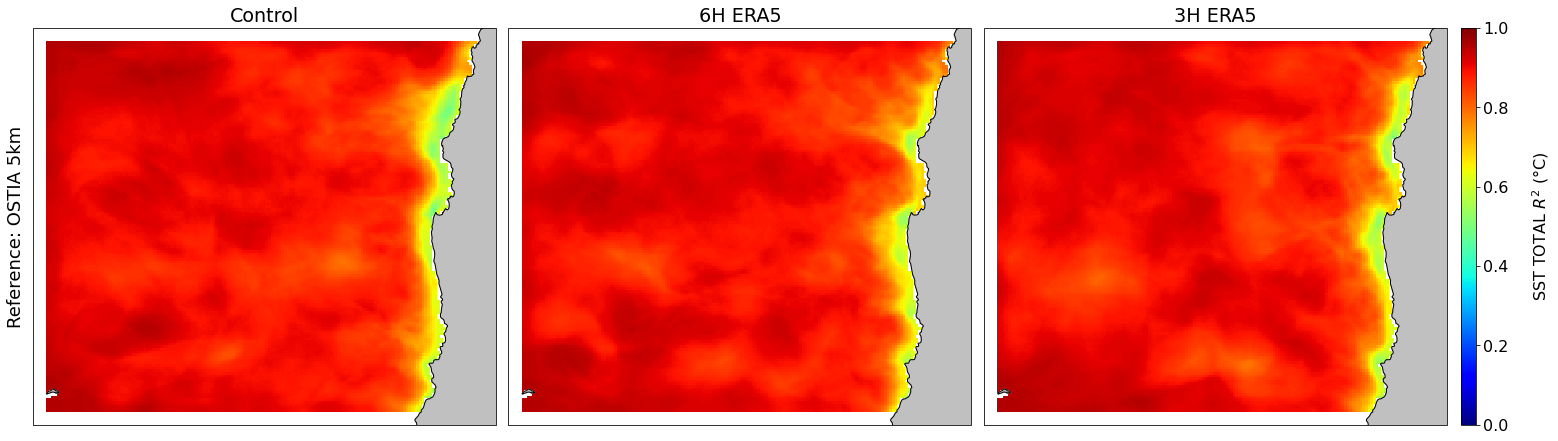

In [34]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Control','6H ERA5','3H ERA5']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='jet'
norm=mcolors.Normalize(0,1)
m=ax[0].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_corr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_6H_bias.lon,testsim_6H_bias.lat, testsim_6H_corr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_3H_bias.lon,testsim_3H_bias.lat, testsim_3H_corr**2, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST TOTAL $R^2$ (°C)')

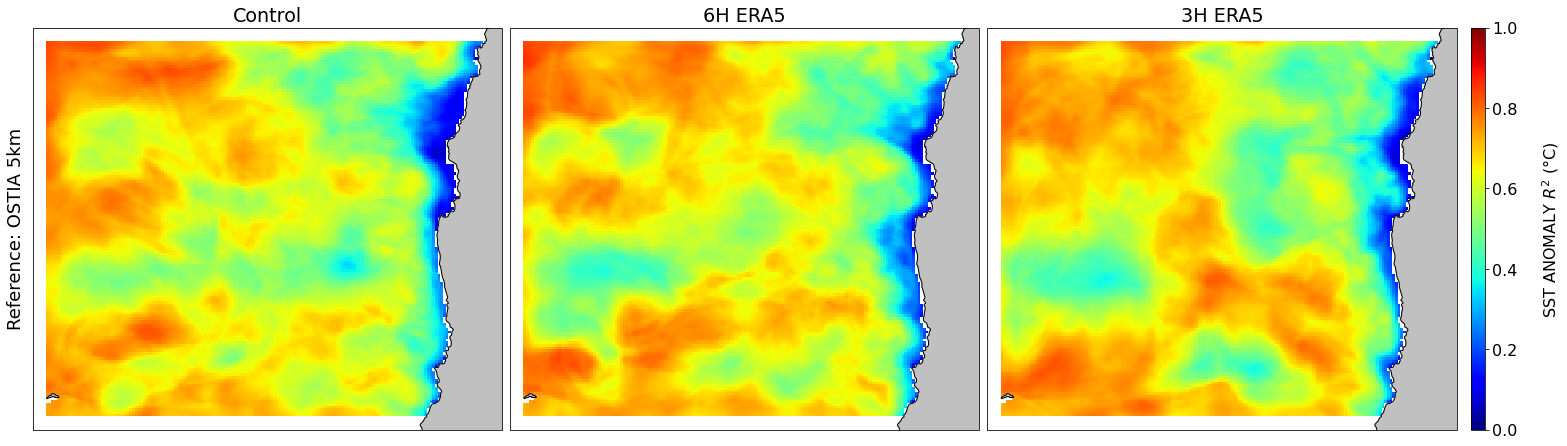

In [23]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['Control','6H ERA5','3H ERA5']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='jet'
norm=mcolors.Normalize(0,1)
m=ax[0].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_acorr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_6H_bias.lon,testsim_6H_bias.lat, testsim_6H_acorr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_3H_bias.lon,testsim_3H_bias.lat, testsim_3H_acorr**2, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST ANOMALY $R^2$ (°C)')

Overall, its seems that in terms of bias and errors the simulations are pretty similar. But in terms of correlations there is a sustantial gain in the Coquimbo bay SST. 
I will check the coastal timeseries for more information now...

In [31]:
with ProgressBar():
    mask = regionmask.mask_geopandas(coastmask, reference.lon, reference.lat)
    mask = mask==0
    mask = ((~np.isnan(reference.sst[0])) & mask).load()
    mask[:85]  = 0
    mask[-55:] = 0
    
    reference_coast            = ostia['sst'].where(mask==1).mean(['lat','lon']).to_series()
    testsim_control_bias_coast = testsim_control_bias.where(mask==1).mean(['lat','lon']).to_series()
    testsim_6H_bias_coast      = testsim_6H_bias.where(mask==1).mean(['lat','lon']).to_series()
    testsim_3H_bias_coast      = testsim_3H_bias.where(mask==1).mean(['lat','lon']).to_series()

[########################################] | 100% Completed | 104.99 ms
[########################################] | 100% Completed | 24.87 s


Text(0.0, 1.0, '29.86S 71.55W (Coquimbo Bay) sea surface temperature')

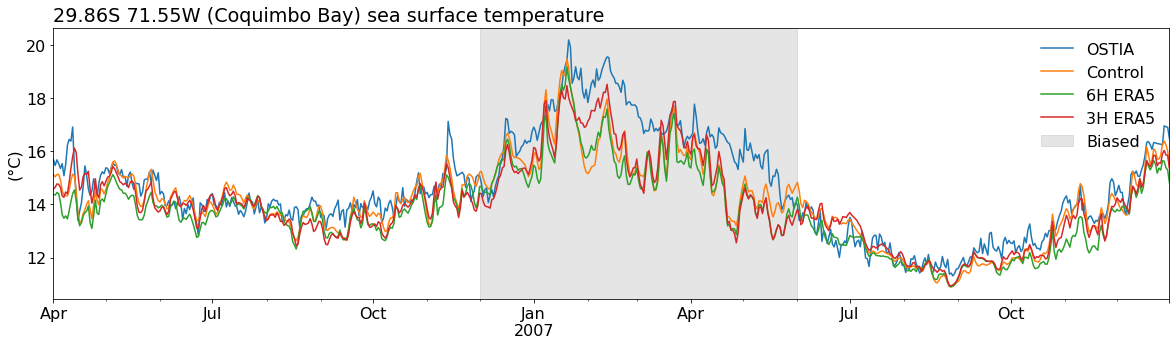

In [99]:
#Plot coast averages time series for each model

fig = plt.figure(figsize=(20,5))
reference_coast.plot(label='OSTIA')
(reference_coast+testsim_control_bias_coast).plot(label='Control')
(reference_coast+testsim_6H_bias_coast).plot(label='6H ERA5')
(reference_coast+testsim_3H_bias_coast).plot(label='3H ERA5')

plt.axvspan("2006-12","2007-06", color='grey', alpha=0.2, label='Biased')

plt.legend(ncol=1, loc='upper right', frameon=False)
plt.xlabel("")
plt.ylabel("(°C)")
plt.title("29.86S 71.55W (Coquimbo Bay) sea surface temperature", loc='left')


In [33]:
from scipy.stats import pearsonr
statistics = pd.DataFrame([], index=['Control','6H ERA5','3H ERA5'], columns=['MBIAS','RMSE','R2'])
statistics['MBIAS'] = [x.mean() for x in [testsim_control_bias_coast, testsim_6H_bias_coast, testsim_3H_bias_coast]]
statistics['RMSE']  = [(x**2).mean()**0.5 for x in [testsim_control_bias_coast, testsim_6H_bias_coast, testsim_3H_bias_coast]]
statistics['R2']    = [pearsonr(x+reference_coast, reference_coast)[0]**2 for x in [testsim_control_bias_coast, testsim_6H_bias_coast, testsim_3H_bias_coast]]
statistics

,MBIAS,RMSE,R2
Control,-0.496478,0.953435,0.816989
6H ERA5,-0.832042,1.148093,0.836879
3H ERA5,-0.562398,0.940148,0.844353


In [36]:
#Cross section in a target latitude...
with ProgressBar():
    tlat = -30.5
    simulation_eta = np.where(np.sign(testsim_control.lat_rho-tlat).diff('eta_rho')!=0)[0][0]+2

    cross_sections            = {keys:None for keys in ['control','6H','3H']}
    cross_sections['control'] = xr.merge([testsim_control[['v','temp','z_rho']].sel(eta_rho=simulation_eta), grid.h.sel(eta_rho=simulation_eta)]).load()
    cross_sections['6H']      = xr.merge([testsim_6H[['v','temp','z_rho']].sel(eta_rho=simulation_eta), grid.h.sel(eta_rho=simulation_eta)]).load()
    cross_sections['3H']      = xr.merge([testsim_3H[['v','temp','z_rho']].sel(eta_rho=simulation_eta), grid.h.sel(eta_rho=simulation_eta)]).load()

[########################################] | 100% Completed | 135.09 s
[########################################] | 100% Completed | 176.40 s
[########################################] | 100% Completed | 175.71 s


In [100]:
cross_sections_means = {keys:None for keys in cross_sections.keys()}
cross_sections_means['control'] = cross_sections['control'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()
cross_sections_means['control'].coords['z'] = cross_sections_means['control'].z_rho

cross_sections_means['6H'] = cross_sections['6H'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()
cross_sections_means['6H'].coords['z'] = cross_sections_means['6H'].z_rho

cross_sections_means['3H'] = cross_sections['3H'].groupby('time.season').mean().sel(season=['DJF','MAM']).mean('season').load()
cross_sections_means['3H'].coords['z'] = cross_sections_means['3H'].z_rho

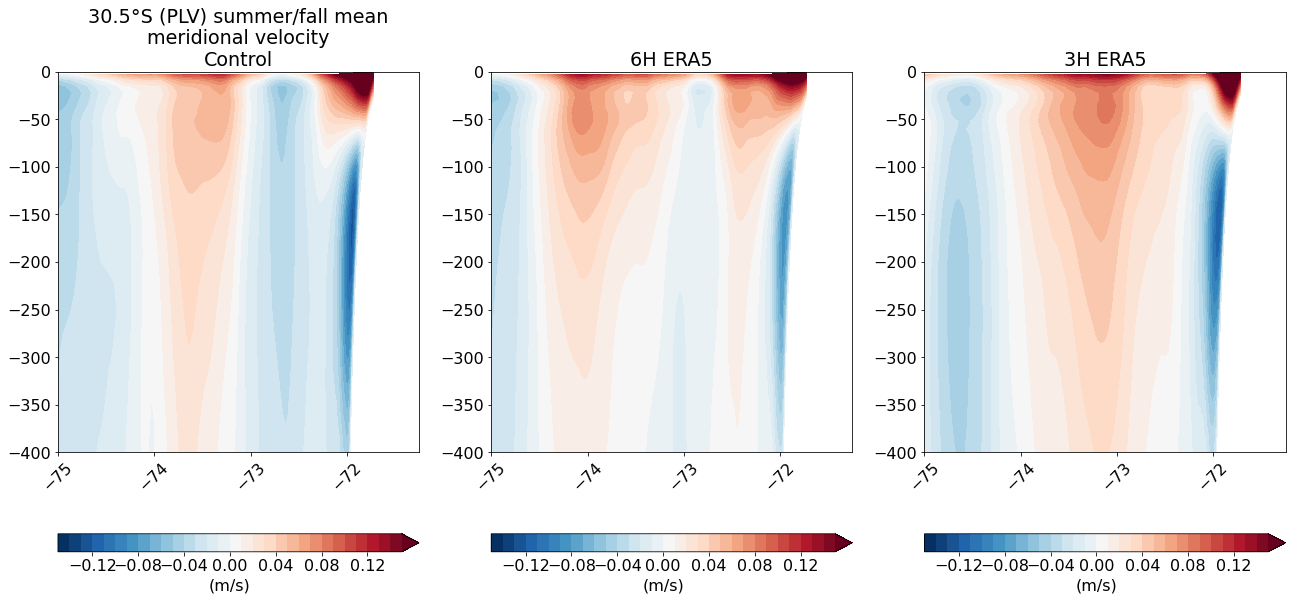

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(22,10))
plt.rc('font',size=16)
cmap = 'RdBu_r'
vmin,vmax=-0.15,0.15
m='DJF'
cross_sections_means['control'].dropna('xi_rho').v.plot.contourf(y='z', ax=ax[0],x='lon_rho', levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})

cross_sections_means['6H'].dropna('xi_rho').v.plot.contourf(y='z', ax=ax[1],x='lon_rho', levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})

cross_sections_means['3H'].dropna('xi_rho').v.plot.contourf(y='z', ax=ax[2], x='lon_rho', levels=np.arange(vmin,vmax+0.01,0.01), cmap=cmap, cbar_kwargs={'label':'(m/s)', 'orientation':'horizontal'})


titles = ['30.5°S (PLV) summer/fall mean\nmeridional velocity\nControl', '6H ERA5', '3H ERA5']
for i,axis in enumerate(ax.ravel()):
    axis.set_xlabel('')
    axis.set_ylabel('')
    axis.set_title(titles[i])
    axis.tick_params(axis='x', rotation=45)
    axis.set_xlim(-75, -71.25)
    axis.set_ylim(-400,0)